In [1]:
import json
import sys
from os import listdir
from os.path import isfile, join
import re
import string
import pandas as pd
import numpy as np

import time
from tqdm import tqdm
from typing import List

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
# from keras.preprocessing.sequence import pad_sequences

import transformers
from transformers import AutoTokenizer, AutoModel, utils
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, TrainingArguments
from datasets import Dataset
transformers.logging.set_verbosity_error()
utils.logging.set_verbosity_error()  # Suppress standard warnings

from bertviz import model_view, head_view


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import eli5
from eli5.lime import TextExplainer
# from captum.attr import IntegratedGradients
# import matplotlib.pyplot as plt


from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

## Data

In [2]:
sen_train_data = pd.read_csv('train_sentence_data.csv')
sen_test_data = pd.read_csv('test_sentence_data.csv')
sen_val_data = pd.read_csv('val_sentence_data.csv')

In [3]:
sen_train_data = sen_train_data.drop(['File_id'],axis=1)
sen_test_data = sen_test_data.drop(['File_id'],axis=1)
sen_val_data = sen_val_data.drop(['File_id'],axis=1)

In [4]:
def get_20(data):
    data_1 = data.loc[data['Status'] ==1].iloc[:20]
    data_2 = data.loc[data['Status'] ==0].iloc[:20]
    frames = [data_1, data_2]
    return pd.concat(frames)

sen_train_data = get_20(sen_train_data) 
sen_test_data = get_20(sen_test_data)
sen_val_data = get_20(sen_val_data)

In [5]:
sen_train_data=sen_train_data.sample(frac = 1)
sen_test_data=sen_test_data.sample(frac = 1)
sen_val_data=sen_val_data.sample(frac = 1)

In [6]:
sen_train_data.to_csv('Train_auto.csv',index=False)
sen_test_data.to_csv('Test_auto.csv',index=False)
sen_val_data.to_csv('val_auto.csv',index=False)

In [7]:
sen_train_data.Status.value_counts()

1    20
0    20
Name: Status, dtype: int64

In [8]:
# Load train and validation datasets from CSV files
train_dataset = Dataset.from_csv('Train_auto.csv')
val_dataset = Dataset.from_csv('val_auto.csv')
test_dataset = Dataset.from_csv('Test_auto.csv')

# Rename the columns to 'text' and 'label' to match the expected format for sequence classification
train_dataset = train_dataset.rename_column('Sentence', 'text').rename_column('Status', 'label')
val_dataset = val_dataset.rename_column('Sentence', 'text').rename_column('Status', 'label')
test_dataset = test_dataset.rename_column('Sentence', 'text').rename_column('Status', 'label')


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/admin/.cache/huggingface/datasets/csv/default-ffd13070a655c781/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/admin/.cache/huggingface/datasets/csv/default-1e96cdec1985f3fa/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/admin/.cache/huggingface/datasets/csv/default-e6b817204583254c/0.0.0. Subsequent calls will reuse this data.


In [9]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/allenai-specter')

# Define a function to tokenize the text and create input sequences
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True,max_length=512)

# Apply the tokenization function to the train and validation datasets
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [10]:
model = AutoModelForSequenceClassification.from_pretrained('sentence-transformers/allenai-specter', num_labels=2)

In [11]:
# Train the model
training_args = TrainingArguments(
    output_dir='./results/specter',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [12]:
trainer = Trainer(
    model=model,                     # the instantiated Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
)
trainer.train()

/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'train_runtime': 70.8475, 'train_samples_per_second': 1.694, 'train_steps_per_second': 0.127, 'train_loss': 0.7036408318413628, 'epoch': 3.0}


TrainOutput(global_step=9, training_loss=0.7036408318413628, metrics={'train_runtime': 70.8475, 'train_samples_per_second': 1.694, 'train_steps_per_second': 0.127, 'train_loss': 0.7036408318413628, 'epoch': 3.0})

In [13]:
# Evaluate the model
eval_results = trainer.evaluate(test_dataset)
print(eval_results)

{'eval_loss': 0.694731593132019, 'eval_runtime': 6.6634, 'eval_samples_per_second': 6.003, 'eval_steps_per_second': 0.15, 'epoch': 3.0}
{'eval_loss': 0.694731593132019, 'eval_runtime': 6.6634, 'eval_samples_per_second': 6.003, 'eval_steps_per_second': 0.15, 'epoch': 3.0}


In [14]:
def model_adapter(texts: List[str]):
    
    all_scores = []

    for i in tqdm(range(0, len(texts), 64)):

        batch = texts[i:i+64]
        #print(batch)
        
        # use bert encoder to tokenize text 
        encoded_input = tokenizer(batch, 
          return_tensors='pt', 
          padding=True, 
          truncation=True, 
          max_length=model.config.max_position_embeddings-2)

        # run the model
        output = model(**encoded_input)
        #print(output)
        # by default this model gives raw logits rather 
        # than a nice smooth softmax so we apply it ourselves here
        scores = output[0].softmax(1).detach().numpy()
        #print(scores)

        all_scores.extend(scores)

    return np.array(all_scores)

In [15]:
sen = sen_test_data.Sentence
lab = sen_test_data.Status

In [16]:
specter_exp = TextExplainer(n_samples=5000, random_state=42)
specter_exp.fit(sen[0], model_adapter)
specter_exp.explain_prediction(target_names=list(model.config.id2label.values()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [03:17<00:00,  2.49s/it]
/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Explanation(estimator="SGDClassifier(alpha=0.001, loss='log', penalty='elasticnet',\n              random_state=RandomState(MT19937) at 0x7FCE7F8D8EB8)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='LABEL_0', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='is a', weight=0.09455749719465045, std=None, value=1.0), FeatureWeight(feature='programs', weight=0.07861829514338692, std=None, value=1.0), FeatureWeight(feature='from', weight=0.05780649367506052, std=None, value=1.0), FeatureWeight(feature='to synthesize', weight=0.057717238247157264, std=None, value=1.0), FeatureWeight(feature='small', weight=0.05422073805951692, std=None, value=1.0), FeatureWeight(feature='robust programs', weight=0.05390596945671661, std=None, value=1.0), FeatureWeight(feature='synthesize', weight=0.04923068715865783, std=None, value=1.0), FeatureWeight(feature='a challenging', weight=0.03770382608572045, std=None, value=1.0), FeatureWeight(feature='synthesize robust', weight=0.03536334849282966, std=None, value=1.0), FeatureWeight(feature='small number', weight=0.0021475237056306413, std=None, value=1.0), FeatureWeight(feature='neural', weight=0.0005661106341399047, std=None, value=1.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.14446589224892337, std=None, value=1.0), FeatureWeight(feature='challenging', weight=-0.07048140602381638, std=None, value=1.0), FeatureWeight(feature='networks', weight=-0.06941207593497527, std=None, value=1.0), FeatureWeight(feature='examples', weight=-0.051716267937491574, std=None, value=1.0), FeatureWeight(feature='programs from', weight=-0.02391750906197453, std=None, value=1.0), FeatureWeight(feature='of examples', weight=-0.012579957302960819, std=None, value=1.0), FeatureWeight(feature='neural networks', weight=-0.0007208297812123492, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.5370678132065265, score=-0.1485437895621129, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='training neural networks to synthesize robust programs from a small number of examples is a challenging task', spans=[('neural', [(9, 15)], 0.0005661106341399047), ('networks', [(16, 24)], -0.06941207593497527), ('synthesize', [(28, 38)], 0.04923068715865783), ('programs', [(46, 54)], 0.07861829514338692), ('from', [(55, 59)], 0.05780649367506052), ('small', [(62, 67)], 0.05422073805951692), ('examples', [(78, 86)], -0.051716267937491574), ('challenging', [(92, 103)], -0.07048140602381638), ('neural networks', [(9, 15), (16, 24)], -0.0007208297812123492), ('to synthesize', [(25, 27), (28, 38)], 0.057717238247157264), ('synthesize robust', [(28, 38), (39, 45)], 0.03536334849282966), ('robust programs', [(39, 45), (46, 54)], 0.05390596945671661), ('programs from', [(46, 54), (55, 59)], -0.02391750906197453), ('small number', [(62, 67), (68, 74)], 0.0021475237056306413), ('of examples', [(75, 77), (78, 86)], -0.012579957302960819), ('is a', [(87, 89), (90, 91)], 0.09455749719465045), ('a challenging', [(90, 91), (92, 103)], 0.03770382608572045)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=0.2930096818110362, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.14446589224892337, std=None, value=1.0)], pos_remaining=0, neg_remaining=0)), heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [17]:
weights = specter_exp.explain_weights(top=None)


/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
weights

Weight?,Feature
+0.144,<BIAS>
+0.070,challenging
+0.069,networks
+0.052,examples
+0.024,programs from
+0.013,of examples
+0.001,neural networks
-0.001,neural
-0.002,small number
-0.035,synthesize robust


/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


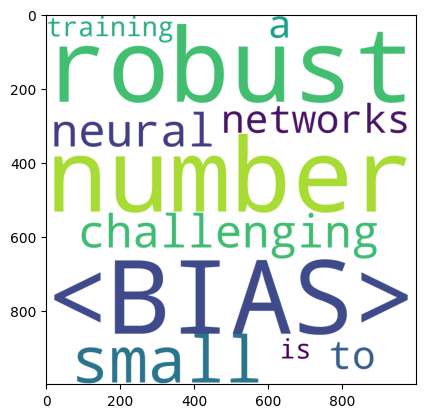

In [17]:
weights = specter_exp.explain_weights()

sen_positivie_words= {}

for i in weights.targets[0].feature_weights.pos:
    #print(i.feature)
    g = sen_positivie_words.get(i.feature,-1)
    if g==-1:
        sen_positivie_words[i.feature]=1
    else:
        sen_positivie_words[i.feature]+=1
        

sen_negative_words= {}

for i in weights.targets[0].feature_weights.neg:
    #print(i.feature)
    g = sen_negative_words.get(i.feature,-1)
    if g==-1:
        sen_negative_words[i.feature]=1
    else:
        sen_negative_words[i.feature]+=1

        
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(sen_positivie_words)
plt.imshow(wc)


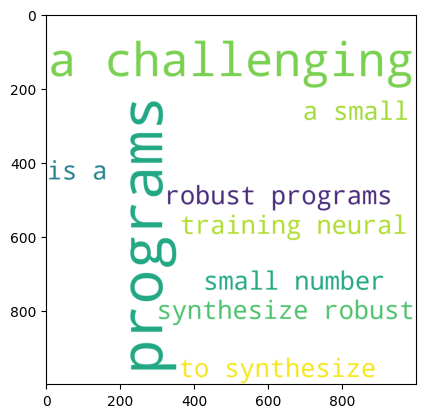

In [18]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(sen_negative_words)
plt.imshow(wc)

## very inportant

In [19]:
# print(weights.targets[0].feature_weights.pos[0].weight,weights.targets[0].feature_weights.pos[0].feature)

In [20]:
# d = specter_exp.explain_prediction()

### Logistic Regression

In [21]:
doc_train_data = pd.read_csv("./complete_sentence/train_processed_data.csv")
doc_test_data = pd.read_csv("./complete_sentence/train_processed_data.csv") 

In [22]:
doc_train_data = get_20(doc_train_data)
doc_test_data = get_20(doc_test_data)

In [23]:
doc_train_data.head()

,File_id,Paper_text,Status
0,304.pdf.json,training neural networks to synthesize robust ...,1
1,305.pdf.json,data compression is a fundamental and well-stu...,1
2,306.pdf.json,deep learning has shown great success in a var...,1
3,307.pdf.json,the most useful applications of dialog systems...,1
4,308.pdf.json,generative adversarial networks (gans)(goodfel...,1


In [24]:
doc_train_text = doc_train_data.Paper_text.values.tolist()
doc_train_status = doc_train_data.Status.values.tolist()

doc_test_text = doc_test_data.Paper_text.values.tolist()
doc_test_status = doc_test_data.Status.values.tolist()

In [25]:
class Padding(BaseEstimator, TransformerMixin):
    
    def __init__(self,model,tokenizer):
        self.model = model # Configure model to return attention values
        self.tokenizer = tokenizer
        self.mxlenght = 400
        print('\n>>>>>>>init() called.\n')

    def fit(self, X, y = None):
        print('\n>>>>>>>fit() called.\n')
        return self
    

    def transform(self, X, y = None):
        embeddings = []
        for i in tqdm(X):
            temp = [] 
            sentence_list = i.split(".")
            for i in sentence_list:
                if len(i)==0:
                    continue
                encoded_input = tokenizer(i,return_tensors='pt', padding=True, truncation=True,max_length=model.config.max_position_embeddings-2)
                output = model(**encoded_input)
                pred = np.argmax(output[0].softmax(1).detach().numpy())
                temp.append(pred)
            size = self.mxlenght - len(temp)
            if size > 0:
                temp.extend([-1]*size)
            elif size < 0:
                temp = temp[0:self.mxlenght]
            else:
                pass
            embeddings.append(temp)
        return embeddings

In [26]:
pipe1 = Pipeline(steps=[
                       ('Documnet Embeddings', Padding(model,tokenizer)), # this will trigger a call to __init__
                       ('Logistic Regression', LogisticRegression(solver='lbfgs')),

])

pipe1.fit(doc_train_text, doc_train_status)
pipe1.score(doc_test_text,doc_test_status)


>>>>>>>init() called.


>>>>>>>fit() called.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [37:45<00:00, 56.64s/it]
/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [22:48<00:00, 34.22s/it]


0.95

In [27]:
target =['Reject','Accept']
doc = doc_test_text[0]
pipe1_exp = TextExplainer(n_samples=10,random_state=42)
pipe1_exp.fit(doc, pipe1.predict_proba)
pipe1_exp.show_prediction(target_names= target)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:50<00:00, 41.06s/it]
/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
weights = pipe1_exp.explain_weights(top= None)
positivie_words= {}

for i in weights.targets[0].feature_weights.pos:
    #print(i.feature)
    g = positivie_words.get(i.feature,-1)
    if g==-1:
        positivie_words[i.feature]=1
    else:
        positivie_words[i.feature]+=1
        

negative_words= {}

for i in weights.targets[0].feature_weights.neg:
    #print(i.feature)
    g = negative_words.get(i.feature,-1)
    if g==-1:
        negative_words[i.feature]=1
    else:
        negative_words[i.feature]+=1
# print(weights.targets[0].feature_weights.pos[0].weight,weights.targets[0].feature_weights.pos[0].feature)

/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


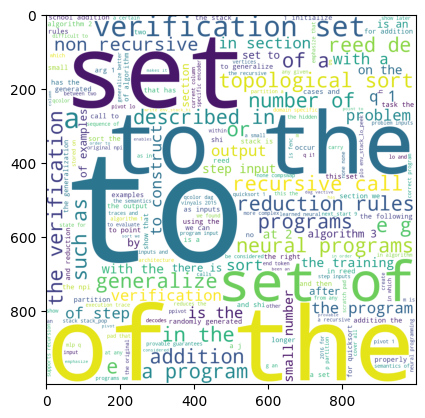

In [29]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(positivie_words)
plt.imshow(wc)

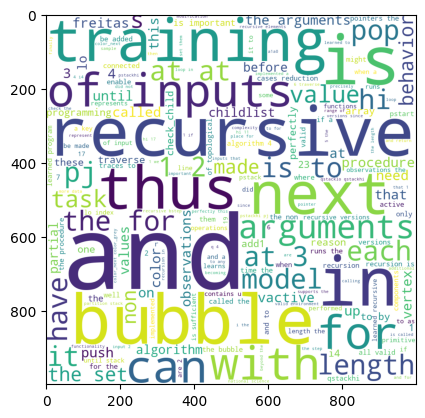

In [30]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(negative_words)
plt.imshow(wc)

In [34]:
def print_prediction(doc):
    #print(doc)
    y_pred = pipe1.predict_proba([doc])[0]
    tar =['Reject','Accept']
    for target, prob in zip(tar, y_pred):
        print("{:.3f} {}".format(prob, target))

In [35]:
print_prediction(doc_test_text[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.55s/it]

0.274 Reject
0.726 Accept


## SVM CLASSIFIER

In [36]:
class CustomEmbedding(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.model_name = "sentence-transformers/bert-base-nli-mean-tokens"
        self.model = AutoModel.from_pretrained(self.model_name, output_attentions=True)  # Configure model to return attention values
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        print('\n>>>>>>>init() called.\n')

    def fit(self, X, y = None):
        print('\n>>>>>>>fit() called.\n')
        return self
    
    def mean_pooling(self,model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


    def bert(self,text):
        encoded_input = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        inputs = self.tokenizer.encode(text, return_tensors='pt')  # Tokenize input text

        outputs = self.model(inputs)  # Run model
        attention = outputs[-1]  # Retrieve attention from model outputs

        tokens = self.tokenizer.convert_ids_to_tokens(inputs[0]) 
        sentence_embeddings = self.mean_pooling(outputs, encoded_input['attention_mask'])
        return sentence_embeddings.detach().numpy()[0].tolist()

    def transform(self, X, y = None):
        embeddings = []
        for i in X:
            emb = self.bert(i)
            embeddings.append(emb)
        #print(embeddings)
        return embeddings
        

In [37]:
pipe2 = Pipeline(steps=[
                       ('Bert Embeddings', CustomEmbedding()),    # this will trigger a call to __init__
                       ('Support Vector Classifier', SVC(kernel='rbf',probability=True))
])



>>>>>>>init() called.



In [38]:
sen_text = sen_train_data['Sentence']
sen_label = sen_train_data['Status']
pipe2.fit(sen_text, sen_label)


>>>>>>>fit() called.



Pipeline(steps=[('Bert Embeddings', CustomEmbedding()),
                ('Support Vector Classifier', SVC(probability=True))])

In [39]:
sen_test_text = sen_test_data['Sentence']
sen_test_lab = sen_test_data['Status']
pipe2.score(sen_test_text,sen_test_lab)

0.5

In [40]:
target =['Reject','Accept']
doc = 'however, models that make use of this strategy eventually fail after a certain level of complexity (e'
pipe2_exp = TextExplainer(random_state=42)
pipe2_exp.fit(doc, pipe2.predict_proba)
pipe2_exp.show_prediction(target_names= target)

/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
def print_prediction_1(doc):
    print(doc)
    y_pred = pipe2.predict_proba([doc])[0]
    tar =['Reject','Accept']
    for target, prob in zip(tar, y_pred):
        print("{:.3f} {}".format(prob, target))

In [42]:
pipe2_exp.explain_weights(target_names=target)

/Users/admin/anaconda3/envs/Newra/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+0.097,eventually
+0.091,of this
+0.049,however
+0.043,level
+0.038,<BIAS>
+0.035,complexity e
+0.027,strategy
+0.007,a
-0.022,certain level
-0.034,level of


In [43]:
print(pipe2.classes_) 
print(pipe2_exp.metrics_ )

[0 1]
{'mean_KL_divergence': 0.001884427730794357, 'score': 0.9741486475426868}


In [ ]:
class Padding_2(BaseEstimator, TransformerMixin):
    
    def __init__(self,model):
        self.model = model # Configure model to return attention values
        self.tokenizer = tokenizer
        self.mxlenght = 400
        print('\n>>>>>>>init() called.\n')

    def fit(self, X, y = None):
        print('\n>>>>>>>fit() called.\n')
        return self
    

    def transform(self, X, y = None):
        embeddings = []
        for i in X:
            temp = [] 
            sentence_list = i.split(".")
            for i in sentence_list:
                if len(i)==0:
                    continue
                pred = model.predict(i)
                temp.append(pred)
            size = self.mxlenght - len(temp)
            if size > 0:
                temp.extend([-1]*size)
            elif size < 0:
                temp = temp[0:self.mxlenght+1]
            else:
                pass
            embeddings.append(temp)
        return embeddings

In [ ]:
pipe3 = Pipeline(steps=[
                       ('Documnet Embeddings', Padding_2(pipe2)), # this will trigger a call to __init__
                       ('Logistic Regression', LogisticRegression(solver='lbfgs')),

])

pipe3.fit(doc_train_text, doc_train_status)
pipe3.score(doc_test_text,doc_test_status)

In [ ]:
def print_prediction_2(doc):
    print(doc)
    y_pred = pipe3.predict_proba([doc])[0]
    tar =['Reject','Accept']
    for target, prob in zip(tar, y_pred):
        print("{:.3f} {}".format(prob, target))

In [ ]:
target =['Reject','Accept']
doc = text[0]
pipe3_exp = TextExplainer(random_state=42)
pipe3_exp.fit(doc, pipe3.predict_proba)
pipe3_exp.show_prediction(target_names= target)

In [ ]:
weights = pipe3_exp.explain_weights(top= None)
positivie_words= {}

for i in weights.targets[0].feature_weights.pos:
    #print(i.feature)
    g = positivie_words.get(i.feature,-1)
    if g==-1:
        positivie_words[i.feature]=1
    else:
        positivie_words[i.feature]+=1
        

negative_words= {}

for i in weights.targets[0].feature_weights.neg:
    #print(i.feature)
    g = negative_words.get(i.feature,-1)
    if g==-1:
        negative_words[i.feature]=1
    else:
        negative_words[i.feature]+=1
# print(weights.targets[0].feature_weights.pos[0].weight,weights.targets[0].feature_weights.pos[0].feature)

In [ ]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(positivie_words)
plt.imshow(wc)

In [ ]:
wc = WordCloud(background_color="white",width=1000,height=1000,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(negative_words)
plt.imshow(wc)